## Heart Disease Prediction

## Introduction:

**Background Information**
<br>
Cardiovascular diseases affect a person's heart or blood vessels. These types of diseases are the leading cause of death across the world which explains why diagnosis at an early stage is important so that patients can get imediate treatment. Heart diseases are a specific group of cardiovascular diseases that refer to conditions specifically affecting the behaviour or structure of the heart. Multiple underlying health conditions and lifestyle choices can increase the likelihood of heart diseases, such as diabetes, obesity, high cholesterol, and high blood pressure. Some possible symptoms of heart disease are heart attacks, heart failure, chest pain, and strokes.

**Our Question:**
<br>
How accurately can we identify whether or not a patient has heart disease based on their age, resting blood pressure, and cholesterol level?



This dataset is a combination of 5 smaller datasets including the Cleveland, Hungarian, Switzerland, Stalog (Heart) Data Set, and Long Beach VA datasets all originally sourced from the UCI Machine Learning Repository. It contains information on health factors of patients and whether or not these patients had heart disease. Important factors that this dataset include are the patients' age, cholesterol level, and resting blood pressure level.



## Preliminary exploratory data analysis:

In [1]:
# import needed libraries
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Reading and scaling the data

In [2]:
# read dataset from web
heart <- read_csv("https://raw.githubusercontent.com/josephsoo/dsci_100_group_12/main/data/heart.csv")


# clean and wrangle into tidy format
# by turning HeartDisease in a factor type and 
# removing rows where cholesterol = 0
heart <- mutate(heart, HeartDisease = as_factor(HeartDisease)) |> filter(Cholesterol != 0)
head(heart)

# for reference: 1 = has heart disease, 0 = does not have heart disease

# scale the dataset and select relevant variables
heart_scaled <- heart|>
    mutate(scaled_Cholesterol = scale(Cholesterol, center = TRUE),
        scaled_RestingBP = scale(RestingBP, center = TRUE),
        scaled_Age = scale(Age, center = TRUE))|>
    select(HeartDisease, scaled_Cholesterol, scaled_RestingBP, scaled_Age)

head(heart_scaled)

Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<fct>
40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0


HeartDisease,scaled_Cholesterol,scaled_RestingBP,scaled_Age
<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
0,0.7499910,0.4037096,-1.3551640
1,-1.0926718,1.5609328,-0.4083824
0,0.6485600,-0.1749020,-1.6707579
1,-0.5178963,0.2879873,-0.5135804
0,-0.8390944,0.9823212,0.1176074
0,1.5952492,-0.7535137,-1.4603620


## Splitting the data

In [3]:
set.seed(3456) 

heart_split <- initial_split(heart_scaled, prop = 0.75, strata = HeartDisease)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

## Creating tables to summarize the training data

In [13]:
# Using only training data, summarize the data in at least one table (this is exploratory data analysis). 
# An example of a useful table could be one that reports the number of observations in each class, 
# the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 

# number of observations in each class of heart disease
heart_disease_count <- heart_train |> group_by(HeartDisease) |> summarize(n = n())
heart_disease_count

# averages of each predictor variable
predictor_means <- heart_train |> select(-HeartDisease) |> map_df(mean)
colnames(predictor_means) <- c("scaled_Cholesterol_mean", "scaled_RestingBP_mean", "scaled_Age_mean")
predictor_means

HeartDisease,n
<fct>,<int>
0,292
1,267


scaled_Cholesterol_mean,scaled_RestingBP_mean,scaled_Age_mean
<dbl>,<dbl>,<dbl>
0.0008714988,0.02797431,0.03668586


## Creating data visualizations of the training data

We have made 3 scatter plots which show the distribution and relationship between all combinations of our predictor variables. The reason why we used only 2D visualizations is because 3D visualizations can be confusing and hard to look at and determine relationships. These plots allow us to see if there are any general patterns in the data, as well as compare the distributions of predictor variables

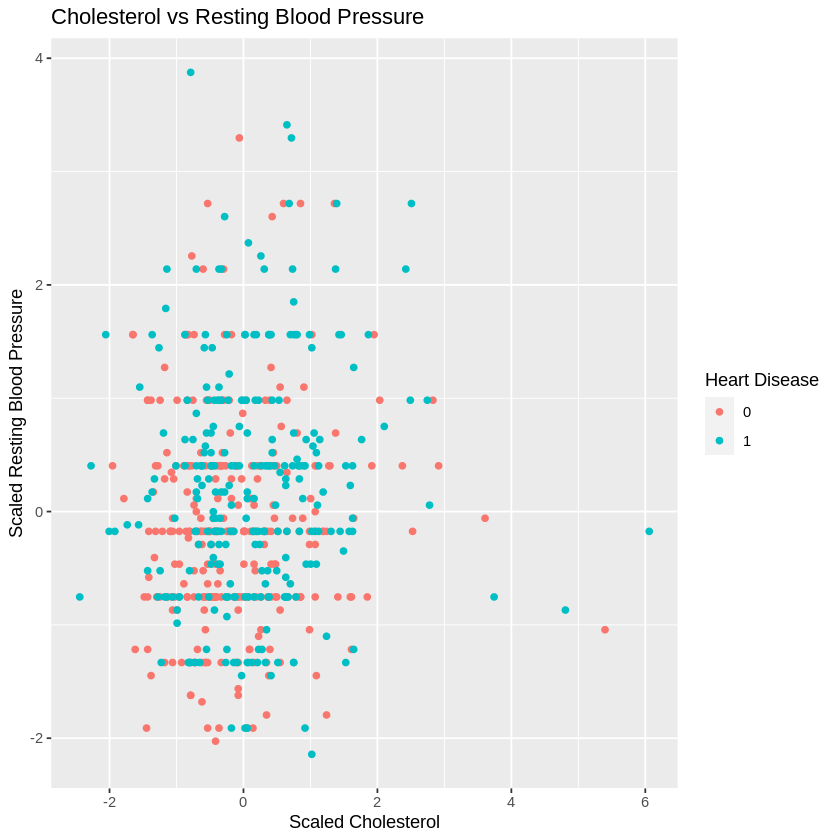

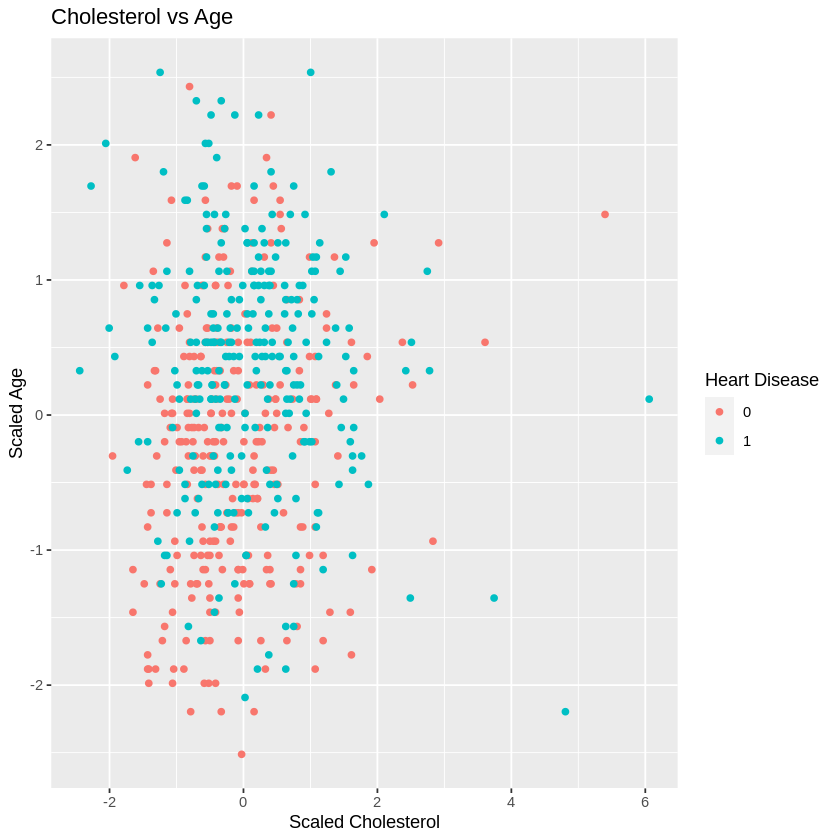

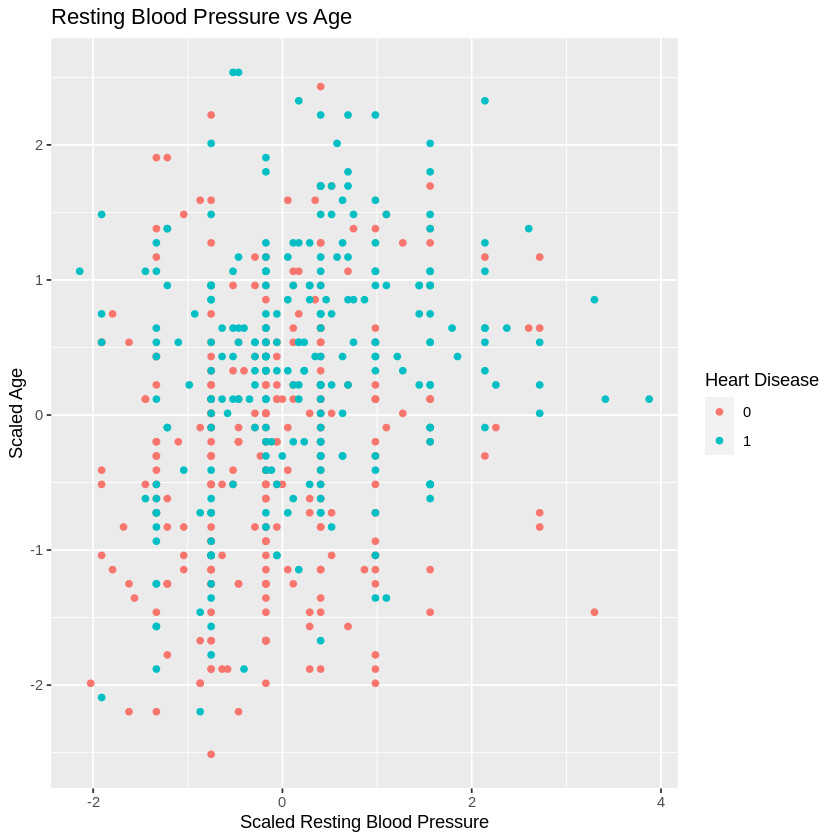

In [17]:
# Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do 
# (this is exploratory data analysis). An example of a useful visualization could be one that compares the 
# distributions of each of the predictor variables you plan to use in your analysis.

cholesterol_resting_bp_plot <- heart_train |> ggplot(aes(x = scaled_Cholesterol, y = scaled_RestingBP, color = HeartDisease)) +
    geom_point() +
    labs(x = "Scaled Cholesterol", y = "Scaled Resting Blood Pressure", color = "Heart Disease", title = "Cholesterol vs Resting Blood Pressure")

cholesterol_age_plot <- heart_train |> ggplot(aes(x = scaled_Cholesterol, y = scaled_Age, color = HeartDisease)) +
    geom_point() +
    labs(x = "Scaled Cholesterol", y = "Scaled Age", color = "Heart Disease", title = "Cholesterol vs Age")

resting_bp_age_plot <- heart_train |> ggplot(aes(x = scaled_RestingBP, y = scaled_Age, color = HeartDisease)) +
    geom_point() +
    labs(x = "Scaled Resting Blood Pressure", y = "Scaled Age", color = "Heart Disease", title = "Resting Blood Pressure vs Age")

cholesterol_resting_bp_plot
cholesterol_age_plot
resting_bp_age_plot

## Distribution of predictors

We can also visualize the distribution of each predictor variable using histograms to see how the data we are working with looks like.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



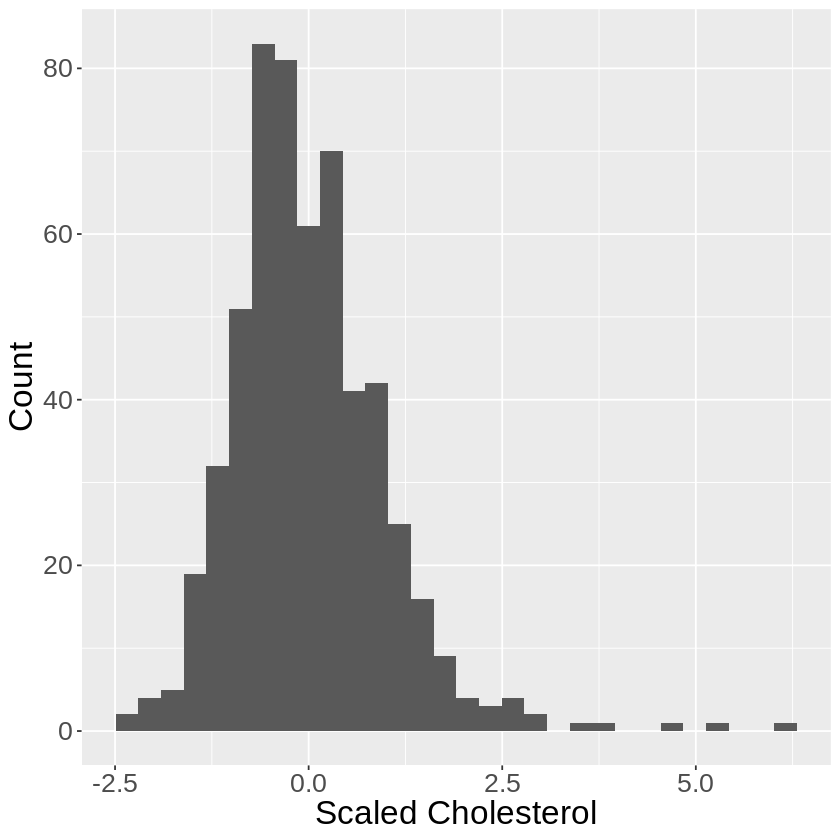

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



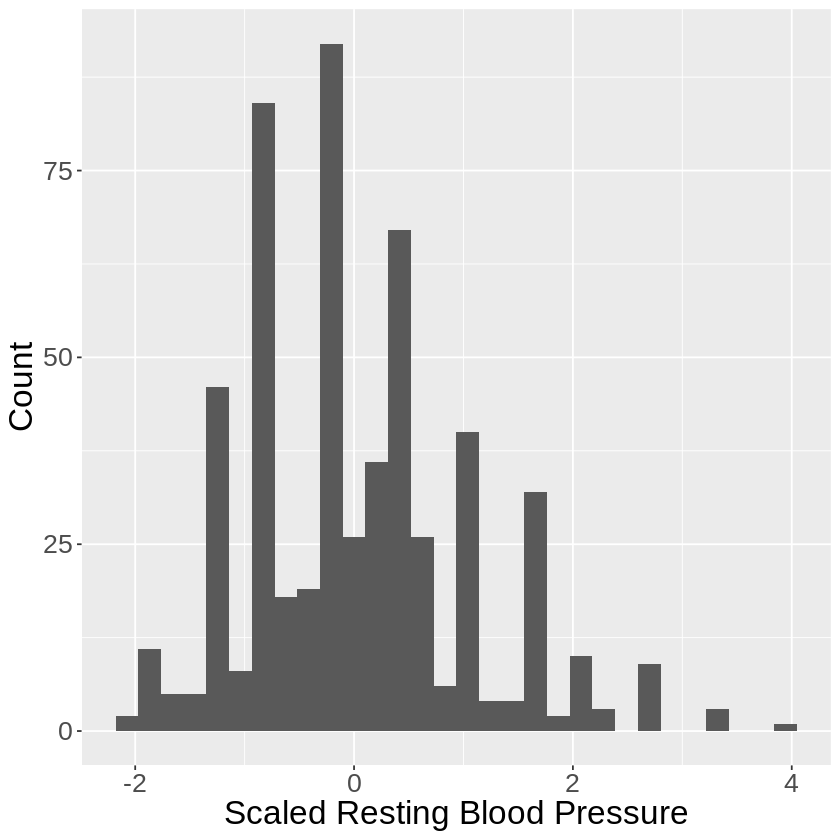

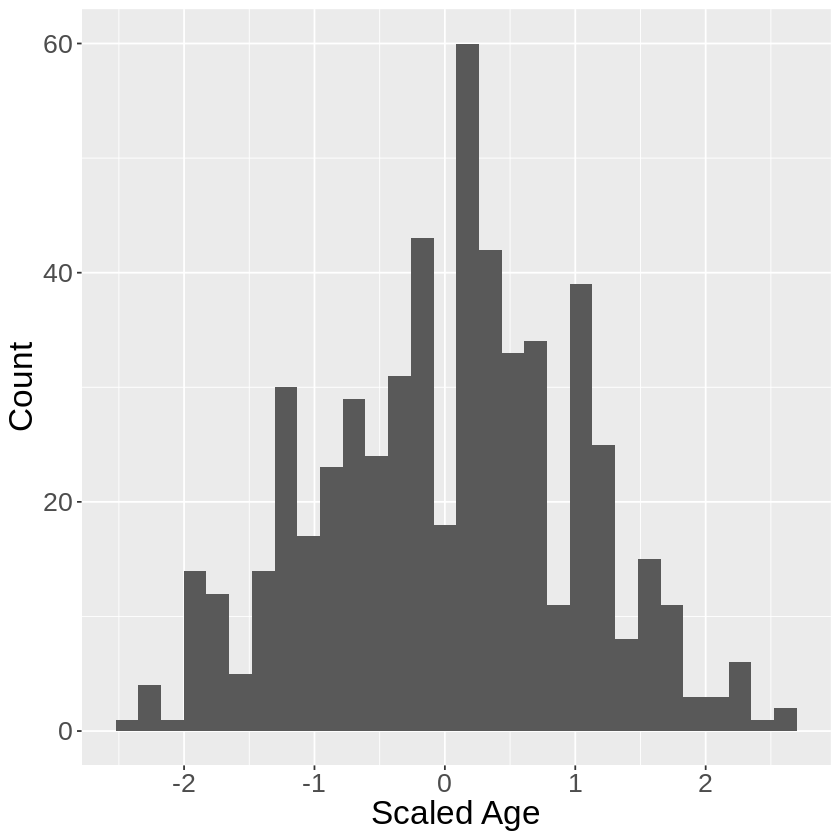

In [15]:
cholesterol_plot <- heart_train |> ggplot(aes(x = scaled_Cholesterol)) +
    geom_histogram() +
    labs(x = "Scaled Cholesterol", y = "Count") +
    theme(text = element_text(size=20))

resting_bp_plot <- heart_train |> ggplot(aes(x = scaled_RestingBP)) +
    geom_histogram() +
    labs(x = "Scaled Resting Blood Pressure", y = "Count") +
    theme(text = element_text(size=20))

age_plot <- heart_train |> ggplot(aes(x = scaled_Age)) +
    geom_histogram() +
    labs(x = "Scaled Age", y = "Count") +
    theme(text = element_text(size=20))

cholesterol_plot
resting_bp_plot
age_plot

## Balancing

Here, we are graphing the distribution of the classifier (Heart disease == 1 or 0)

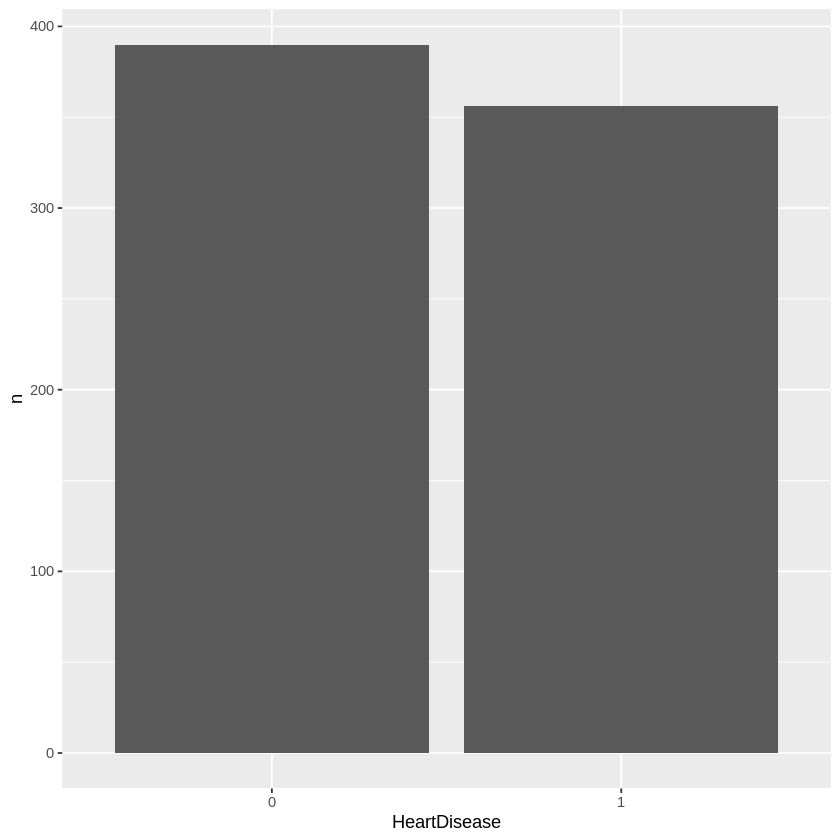

In [9]:
heart_train_count <- heart |>
group_by(HeartDisease) |>
summarize(n = n()) |>
ggplot(aes(x = HeartDisease, y = n))+
geom_bar(stat = "identity")

heart_train_count



Because there are close to equal observations of each class, we should not need to worry about class imbalance

## Methods:

**Variables For Analysis**
<br>
We have 3 potential predictors:
- Age
- Cholestrol 
- Resting Blood Pressure

and the variable we are predicting is:
- Heart Disease


**Method and Rationale**
<br>
Using all the variables in a data set is rarely a good idea in classification problems. 
Therefore, we are going to determine which subset of predictors offers the best performance to our model. One way of doing so is to iteratively build up a model by adding predictors over each iteration. This is known as forward selection.

Once we have found the subset of predictors which gives us the highest accuracy, we will create a classification model using that subset with the best k value. 

Some ways we can visualize the results:
- line graph of accuracy vs number of predictors
- scatter plot with background color of predicted class

In [10]:
heart_subset <- heart_scaled |>
    select(HeartDisease,
           scaled_Age,
           scaled_Cholesterol,
           scaled_RestingBP)
names <- colnames(heart_subset |> select(-HeartDisease))
heart_subset

HeartDisease,scaled_Age,scaled_Cholesterol,scaled_RestingBP
<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
0,-1.35516405,0.7499910,0.4037096
1,-0.40838242,-1.0926718,1.5609328
0,-1.67075792,0.6485600,-0.1749020
1,-0.51358038,-0.5178963,0.2879873
0,0.11760737,-0.8390944,0.9823212
0,-1.46036200,1.5952492,-0.7535137
0,-0.82917426,-0.1290775,-0.1749020
0,0.11760737,-0.6193272,-1.3321253
1,-1.67075792,-0.6362324,0.4037096


In [11]:
formula <- paste("HeartDisease", "~", paste(names, collapse="+"))
formula

[1] "HeartDisease ~ scaled_Age+scaled_Cholesterol+scaled_RestingBP"

In [12]:
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
heart_vfold <- vfold_cv(heart_subset, v = 5, strata = HeartDisease)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("HeartDisease", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        heart_recipe <- recipe(as.formula(model_string), 
                                data = heart_subset) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(heart_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = heart_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,HeartDisease ~ scaled_Age,0.6032483
2,HeartDisease ~ scaled_Age+scaled_Cholesterol,0.6246622
3,HeartDisease ~ scaled_Age+scaled_Cholesterol+scaled_RestingBP,0.6299776


**Interpretation:**
<br>
As shown by the forward selection algorithm, we can see that the most accurate configuration for the model utilizes all three predictors. Therefore, through the forward selection algorithm, we have arrived at a conclusion for our model using a systematic science based approach. 

## Expected outcomes and significance:

**What do you expect to find?**
- In this project, we expect to be able to use the predictors Age, Cholestreol, and resting blood pressure to answer the question: Will someone have heart disease?

**What impact could such findings have?**

- By knowing if someone will ahve heart disease, we could be able to take note of people at risk and monitor them more closely. This might allow people who may be at risk for heart disease to recieve treatment before it become too late

**What future questions could this lead to?**

- If could we identify factors that make people more likely to get heart disease, could we then be able to change the lifestyle of the person to change the chance of them getting heart disease?

